## Autoencoder

In [29]:
import torch
import torch.nn as nn
import torch.optim as optim

import torchvision.transforms as transforms
from torchvision.datasets import MNIST
import torch.utils.data.dataloader as dataloader
from torch.utils.data.dataset import Dataset

from IPython.display import clear_output
import matplotlib.pyplot as plt
import numpy as np
import time
import random

In [30]:
GPU_indx = 0
device = torch.device(GPU_indx if torch.cuda.is_available() else 'cpu')
torch.manual_seed(0)

## Download MNIST dataset

In [31]:
class MNIST_Dataset(Dataset):
    def __init__(self, dataset, train_type='normal'):
        super().__init__()
        self.dataset = dataset
        self.train_type = train_type
        self.transform = transforms.Compose([
            transforms.GaussianBlur(5, sigma=1.2)
        ])

    def __getitem__(self, idx):
        lbl, _ = self.dataset[idx]
        img = torch.clone(lbl)
        if self.train_type == 'occlude':
            r_size = 12
            r_idx = int(random.random()*(27-r_size))
            c_idx = int(random.random()*(27-r_size))
            img[0, r_idx:r_idx+r_size, c_idx:c_idx+r_size] = torch.zeros(r_size)
        elif self.train_type == 'blur':
            img = self.transform(img)
        return img, lbl


    def __len__(self):
        return len(self.dataset)

In [34]:
batch_size = 256

#Create a train and test dataset using the Pytorch MNIST dataloader class
train = MNIST('./data', train=True,  download=True, transform=transforms.ToTensor())
test  = MNIST('./data', train=False, download=True, transform=transforms.ToTensor())

train_type = 'occlude'
dataset_train = MNIST_Dataset(train, train_type=train_type)
dataset_test = MNIST_Dataset(test, train_type=train_type)

#Using the Pytorch dataloader class and the Pytorch datasets we with create itterable dataloader objects
dataloader_train = dataloader.DataLoader(dataset_train, shuffle=True, batch_size=batch_size, num_workers=0, pin_memory=False) 
dataloader_test = dataloader.DataLoader(dataset_test, shuffle=True, batch_size=batch_size, num_workers=0, pin_memory=False)

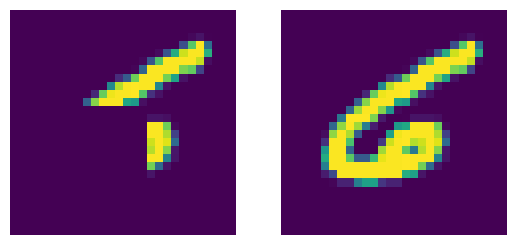

In [37]:
image, lbl = next(iter(dataloader_train))
plt.subplot(1, 2, 1)
plt.imshow(image[0, 0, :])
plt.axis('off')

plt.subplot(1, 2, 2)
plt.imshow(lbl[0, 0, :])
plt.axis('off')
plt.show()

## Create Model

In [19]:
# Model adapted from [https://medium.com/dataseries/convolutional-autoencoder-in-pytorch-on-mnist-dataset-d65145c132ac](https://medium.com/dataseries/convolutional-autoencoder-in-pytorch-on-mnist-dataset-d65145c132ac)

class Encoder(nn.Module):
    def __init__(self, bottleneck):
        super().__init__()
        self.conv = nn.Sequential(
            nn.Conv2d( 1,  8, 3, stride=2, padding=1),   # in_channel=1,out_channel=4, kernel_size=3
            nn.BatchNorm2d(8),
            nn.ReLU(True),
            nn.Conv2d( 8,  24, 3, stride=2, padding=1),   # in_channel=4,out_channel=8, kernel_size=3
            nn.BatchNorm2d(8),
            nn.ReLU(True),
            nn.Conv2d(24, 48, 3, stride=2, padding=0),   # in_channel=8,out_channel=16,kernel_size=3
        )
        self.flatten = nn.Flatten()
        self.linear = nn.Sequential(
            nn.Linear(48*3*3, 64),
            nn.BatchNorm1d(128),
            nn.ReLU(True),
            nn.Linear(128, bottleneck),
        )
        
    def forward(self, x):
        x = self.conv(x)
        x = self.flatten(x)
        x = self.linear(x)
        x = torch.sigmoid(x)    # bound output to be between 0 and 1 so that latent code is bounded
        return x


class Decoder(nn.Module):
    def __init__(self, bottleneck):
        super().__init__()
        self.linear = nn.Sequential(
            nn.Linear(bottleneck, 64),
            nn.BatchNorm1d(64),
            nn.ReLU(True),
            nn.Linear(64, 3*3*16),
        )
        self.unflatten = nn.Unflatten(1, (16, 3, 3))
        self.conv = nn.Sequential(
            nn.ConvTranspose2d(16, 8, 3, stride=2, padding=0),
            nn.BatchNorm2d(8),
            nn.ReLU(True),
            nn.ConvTranspose2d(8,  4, 3, stride=2, padding=1, output_padding=1),
            nn.BatchNorm2d(4),
            nn.ReLU(True),
            nn.ConvTranspose2d(4,  1, 3, stride=2, padding=1, output_padding=1),
        )

    def forward(self, x):
        x = self.linear(x)
        x = self.unflatten(x)
        x = self.conv(x)
        x = torch.sigmoid(x)    # bound output to be between 0 and 1 for displaying image
        return x


class Autoencoder(nn.Module):
    def __init__(self, bottleneck):
        super().__init__()
        self.downsample = Encoder(bottleneck)
        self.upsample = Decoder(bottleneck)

    def forward(self, x):
        x = self.downsample(x)
        x = self.upsample(x)
        return x

    def forward_encode(self, x):
        x = self.downsample(x)
        return x

    def forward_decode(self, x):
        x = self.upsample(x)
        return x

In [20]:
n_epochs = 30
lr = 1e-3

model = Autoencoder(bottleneck=16).to(device)
optimiser = optim.Adam(model.parameters(), lr=lr, weight_decay=1e-5)
loss_fn = nn.MSELoss()
print(model)

Autoencoder(
  (downsample): Encoder(
    (conv): Sequential(
      (0): Conv2d(1, 4, kernel_size=(3, 3), stride=(2, 2), padding=(1, 1))
      (1): BatchNorm2d(4, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (2): ReLU(inplace=True)
      (3): Conv2d(4, 8, kernel_size=(3, 3), stride=(2, 2), padding=(1, 1))
      (4): BatchNorm2d(8, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (5): ReLU(inplace=True)
      (6): Conv2d(8, 16, kernel_size=(3, 3), stride=(2, 2))
    )
    (flatten): Flatten(start_dim=1, end_dim=-1)
    (linear): Sequential(
      (0): Linear(in_features=144, out_features=64, bias=True)
      (1): BatchNorm1d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (2): ReLU(inplace=True)
      (3): Linear(in_features=64, out_features=16, bias=True)
    )
  )
  (upsample): Decoder(
    (linear): Sequential(
      (0): Linear(in_features=16, out_features=64, bias=True)
      (1): BatchNorm1d(64, eps=1e-05, mom

## Model Training

In [21]:
# Generic training algorithm structure (changed loss function calculation)
def model_train(model, dataloader, loss_fn, optimiser, device):
    model.train()
    train_loss = []
    for image, lbl in dataloader:
        # forward pass
        output = model(image.to(device))

        # loss
        loss = loss_fn(output, lbl.to(device))

        # backpropagation
        optimiser.zero_grad()
        loss.backward()
        optimiser.step()

        train_loss.append(loss.detach().cpu().numpy())
    return np.mean(train_loss)

In [9]:
# Generic testing algorithm (changed loss function calculation)
def model_eval(model, dataloader, loss_fn, device):
    model.eval()
    test_loss = []
    with torch.no_grad():
        for image, lbl in dataloader:
            output = model(image.to(device))
            loss = loss_fn(output, lbl.to(device))
            test_loss.append(loss.detach().cpu().numpy())
    return np.mean(test_loss)

In [10]:
def ae_outputs(model, dataloader, device, n=5):
    plt.figure(figsize=(12, 4.5))
    image, _ = next(iter(dataloader))
    model.eval()
    output = model(image.to(device))
    with torch.no_grad():
        for i in range(n): 
            plt.subplot(2, n, i+1)
            plt.imshow(image[i, 0, :, :])
            plt.axis('off')
            
            plt.subplot(2, n, n+i+1)
            plt.imshow(output.cpu().numpy()[i, 0, :, :])
            plt.axis('off')
    plt.show()

[Epoch 30/30] Train Loss: 0.0222, Val Loss: 0.0222, Time: 15.2203s


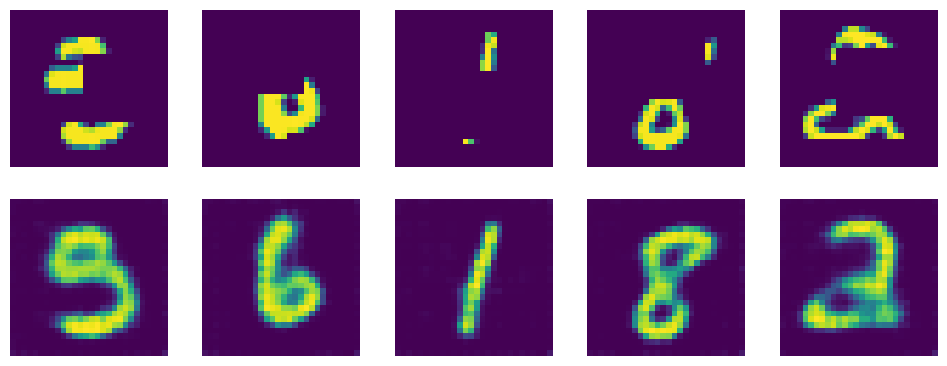

In [22]:
total_train_loss = []
total_val_loss = []
for idx in range(n_epochs):
    clear_output(True)
    start_time = time.time()
    train_loss = model_train(model, dataloader_train, loss_fn, optimiser, device)
    val_loss = model_eval(model, dataloader_test, loss_fn, device)
    total_time = time.time() - start_time
    print(f'[Epoch {idx+1}/{n_epochs}] Train Loss: {train_loss:.4f}, Val Loss: {val_loss:.4f}, Time: {total_time:.4f}s')
    ae_outputs(model, dataloader_test, device)
    total_train_loss.append(train_loss)
    total_val_loss.append(val_loss)

## Data visualisation

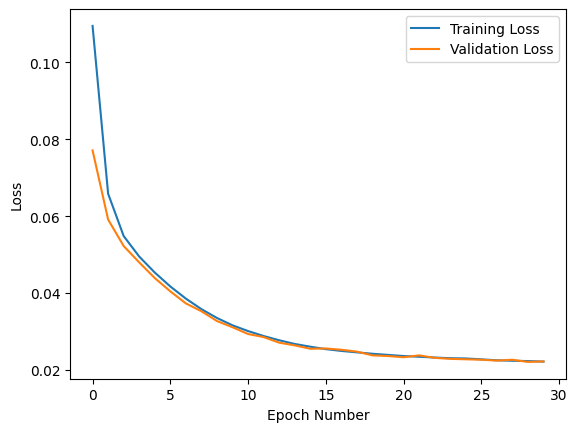

In [23]:
plt.xlabel('Epoch Number')
plt.ylabel('Loss')
plt.plot(total_train_loss, '-', label = 'Training Loss')
plt.plot(total_val_loss, '-', label = 'Validation Loss')
plt.legend()
plt.show()

## Verify if the model is working

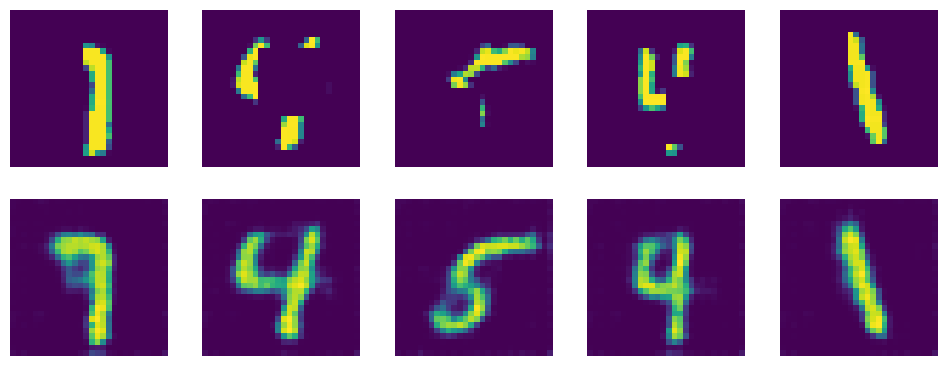

In [28]:
ae_outputs(model, dataloader_test, device)